# sPlot

This notebook explains sPLot and how to compute the sWeights. The technique called sPlot, is able to unfold the contributions of the different sources for a given control variable. It relies on maximum likelihood fits to determine the yields of the various sources. 

Original paper:
M. Pivk & F. Le Diberder, arXiv:physics/0402083, NIMA 555 (2005) 356

In [1]:
# Modules used:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iminuit import cost, Minuit
from numba_stats import truncnorm, truncexpon
import matplotlib.gridspec as gridspec

In [2]:
# Functions I use:

def Generate_toy():
    # Signal
    nsig_sw = 20000
    np_sig_m_sw = np.random.normal(loc=5279, scale=20, size=nsig_sw)
    np_sig_t_sw = np.random.exponential(size=nsig_sw, scale=1)

    # Background:
    nbkg_sw = 150000
    np_bkg_m_sw = np.random.exponential(scale=300, size=nbkg_sw) + xr[0]
    np_bkg_t_sw = np.random.normal(size=nbkg_sw, loc=2.0, scale=2.5)

    # Mass cut:
    m_cut = np_bkg_m_sw < xr[1]
    np_bkg_t_sw = np_bkg_t_sw[m_cut]
    np_bkg_m_sw = np_bkg_m_sw[m_cut]

    # Lifetime cut:
    t_cut = np_bkg_t_sw > 0
    np_bkg_t_sw = np_bkg_t_sw[t_cut]
    np_bkg_m_sw = np_bkg_m_sw[t_cut]

    # Mass distribution
    np_m_sw = np.concatenate([np_sig_m_sw, np_bkg_m_sw])

    # Lifetime distribution
    np_t_sw = np.concatenate([np_sig_t_sw, np_bkg_t_sw])
    return (np_sig_m_sw, np_sig_t_sw, np_bkg_m_sw, np_bkg_t_sw, np_m_sw, np_t_sw)

# Plotting function:
def plot_mass(values, xr, m, bins = 50):
	x = np.linspace(xr[0], xr[1], 1000)

	# Sig and Bkg amount:
	s = m.values['s']
	b = m.values['b']

	sig_values = truncnorm.pdf(x, *xr, m.values['mu'], m.values['sigma'])
	bkg_values = truncexpon.pdf(x, *xr, 0.0, m.values['tau'])

	signal_part = ((xr[1] - xr[0]) / bins) * (len(values) / (s + b)) * s * sig_values 
	background_part = ((xr[1] - xr[0]) / bins) * (len(values) / (s + b)) * b * bkg_values

	# Figure:
	fig = plt.figure(figsize=(8, 8))
	gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

	# Main plot:
	axs = plt.subplot(gs[0])
	counts, bin_edges = np.histogram(values, bins=bins)
	bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
	bin_widths = (bin_edges[1:] - bin_edges[:-1]) / 2
	y_err = np.sqrt(counts)
	axs.errorbar(bin_centers, counts, xerr=bin_widths, yerr=y_err, fmt='o', color='black', label="Data")
	axs.plot(x, signal_part + background_part, label='Total')
	axs.plot(x, signal_part, 'g--', label='Signal')
	axs.plot(x, background_part, 'r--', label='Background')
	# axs.set_title(r'Mass of $\Xi_{cc}^{++}$', fontsize=20)
	axs.set_xlabel('Mass (MeV)', fontsize=10)
	axs.set_ylabel('Counts', fontsize=10)
	axs.tick_params(axis='both', which='major', labelsize=10)
	axs.legend(fontsize=15)
	plt.grid(True)

	# Calculate residuals
	counts_m_sig = truncnorm.pdf(bin_centers, *xr, m.values['mu'], m.values['sigma'])
	counts_m_bkg = truncexpon.pdf(bin_centers, *xr, 0.0, m.values['tau'])
	counts_m = ((xr[1] - xr[0]) / bins) * (len(values) / (s + b)) * s * counts_m_sig + ((xr[1] - xr[0]) / bins) * (len(values) / (s + b)) * b * counts_m_bkg

	residuals = (counts - counts_m) / (np.sqrt(counts))

	# Residuals plot
	axs_residuals = plt.subplot(gs[1])
	axs_residuals.plot(bin_centers, residuals, 'ro', label='Residuals')
	axs_residuals.set_xlabel('Mass (MeV)', fontsize=10)
	axs_residuals.set_ylabel('Pull', color='red', fontsize=10)
	axs_residuals.tick_params(axis='y', labelcolor='red')

	plt.grid(True)
	plt.tight_layout()
	plt.show()

## Toy example: extracting the lifetime distribution of an unstable particle

If a data sample is populated by different sources of events, like signal and background (e.g. Combinatorial), sPlot is able to unfold the contributions of different sourcess for a given variable. Let's construct a dataset with two variables, the invariant mass ($m$) and lifetime ($t$). 

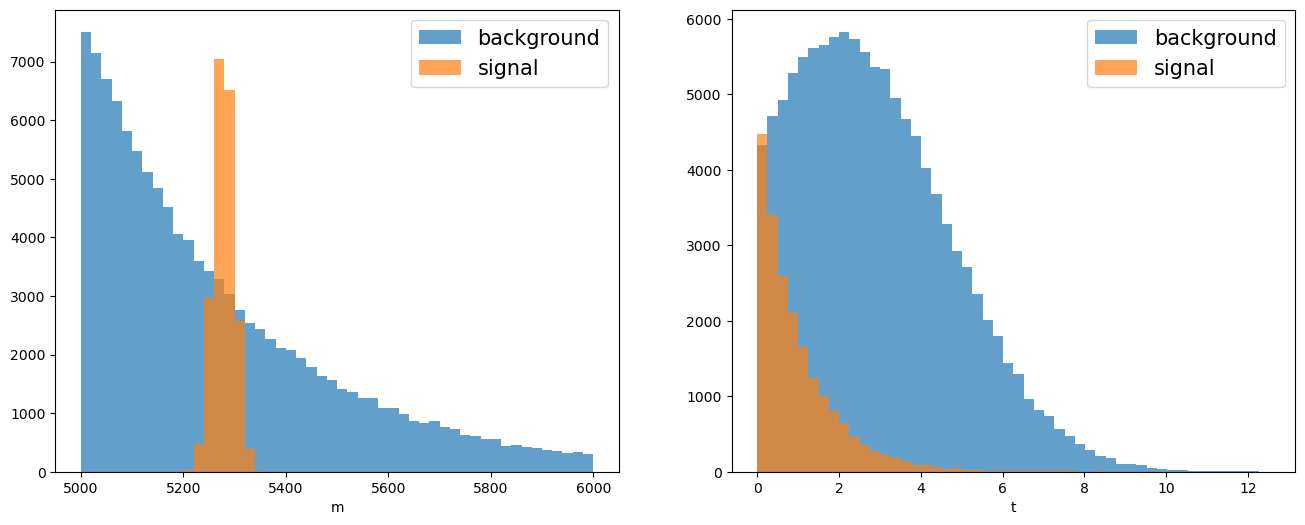

In [3]:
# Generate points:

# mass range:
xr = (5000, 6000)

(np_sig_m_sw, np_sig_t_sw, np_bkg_m_sw, np_bkg_t_sw, np_m_sw, np_t_sw) = Generate_toy()

# Plots the mass and lifetime distribution.
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
_, bins, _ = axs[0].hist(np_bkg_m_sw, bins=50, alpha=.7, label = 'background')
axs[0].hist(np_sig_m_sw, bins=bins, alpha=.7, label = 'signal')
axs[0].set_xlabel("m")
axs[0].legend(fontsize=15)
_, bins, _ = axs[1].hist(np_bkg_t_sw, bins=50, label="background", alpha=.7)
axs[1].hist(np_sig_t_sw, bins=bins, label="signal", alpha=.7)
axs[1].set_xlabel("t")
axs[1].legend(fontsize=15);

In [4]:
# Combine data into arrays
data_arr = np.hstack([
    np.array(np_m_sw).reshape(-1, 1),
    np.array(np_t_sw).reshape(-1, 1),
])

# Create DataFrames
data_df = pd.DataFrame(data_arr, columns=["mass", "lifetime"])

In [5]:
data_df

,mass,lifetime
0,5269.771424,0.827962
1,5308.229140,0.055788
2,5286.560226,0.475994
3,5289.328446,1.381739
4,5300.104157,2.567703
...,...,...
134256,5843.269309,0.880811
134257,5045.243512,4.524381
134258,5059.156021,2.469355
134259,5155.010428,6.180055


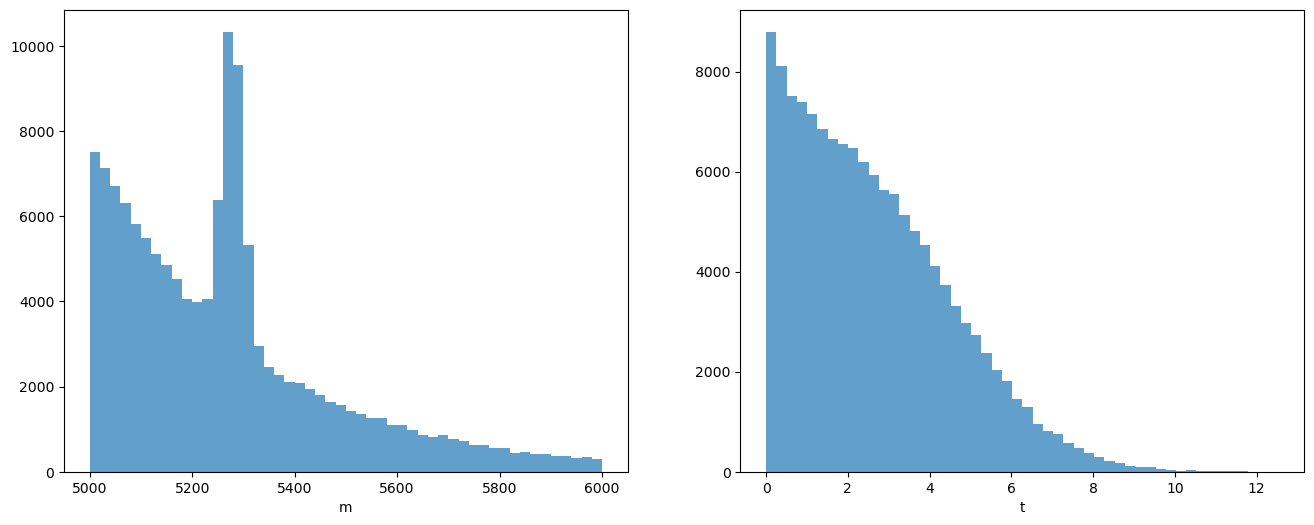

In [6]:
# Plots the mass and lifetime distribution.
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].hist(np_m_sw , bins=50, alpha=.7)
axs[0].set_xlabel("m")
axs[1].hist(np_t_sw , bins=50, alpha=.7)
axs[1].set_xlabel("t");

Data model in discriminant variable Mass ($m$) and control variable Lifetime ($t$)

$$
f(m, t)=N_0 d_0(m) s(t)+N_1 d_1(m) b(t)
$$

- known: signal PDF $d_0(m)$ and background PDF $d_1(m)$ 
- wanted:signal PDF $s(t)$ and background PDF $b(t)$

## The sWeights recipe

- Fit $N_0$ and $N_1$ of the data model in $m: f(m)=N_0 d_0(m)+N_1 d_1(m)$
- With $N_0$ and $N_1$ and their covariance matrix elements $C_{00}$ and $C_{01}$ determine:

$$
w_s(m)=\frac{C_{00} d_0(m)+C_{01} d_1(m)}{N_0 d_0(m)+N_1 d_1(m)}
$$

- $w_s(m)$ is a function of only $m$
- use $w_s(m)$ as weight when filling $t$-histograms to obtain the signal density: $N_0 s(t)$
- background distribution can be obtained by $w_b(m)=1-w_s(m)$
- bin contents in bin $\Delta t$ are

$$
s(\Delta t)=\sum_{\text {entries in } \Delta t} w_s(m)
$$


In [12]:
def compute_sweights(values, yields, V): # with V already worked out
	"""
	Compute sWeights for an arbitrary number of sources.

	Parameters:
	- values: A 2D array (n_samples x n_sources) of PDF values for each source.
	- yields: A 1D array (n_sources) of yields for each source.
	- V: The covariance matrix (n_sources x n_sources).

	Returns:
	- sWeights: A 2D array (n_samples x n_sources) where each column contains the sWeights for a source.
	"""

	pdf_val = np.atleast_2d(values) # Shape: (n_sources, n_samples)
	yields_arr = np.array(yields)  # Shape: (n_sources,)
	V = np.array(V)  # Shape: (n_sources, n_sources)

	# Compute the total sum for normalization
	total_sum = np.dot(yields_arr, pdf_val)  # Shape: (n_samples,)

	# Compute sWeights for each source
	sweights = np.zeros_like(pdf_val)  # Initialize array to store sWeights
	for i in range(V.shape[0]):  # Iterate over sources
		for j in range(V.shape[1]):
			sweights[i, :] = sweights[i, :] + V[i, j] * pdf_val[j, :]

	return sweights/total_sum

## Toy model

### Perform Unbinned maximum likelihood fit:

In [27]:
def density(x, s, b, mu, sigma, tau):
    return s + b, (s * truncnorm.pdf(x, *xr, mu, sigma) + b * truncexpon.pdf(x, *xr, 0.0, tau))
c = cost.ExtendedUnbinnedNLL(np_m_sw, density)
m = Minuit(c, s=20000, b=150000, mu=5279, sigma=20, tau=300)
m.fixed['mu', 'sigma', 'tau'] = True
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.156e+06                 │              Nfcn = 45               │
│ EDM = 3.51e-07 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  19.94e3  │  0.18e3   │            │            │         │         │       │
│ 1 │ b     │  113.6e3  │   0.4e3   │            │            │         │         │       │
│ 2 │ mu    │  5.28e3   │  0.05e3   │            │            │         │         │  yes  │
│ 3 │ sigma │   20.0    │    0.2    │            │            │         │         │  yes  │
│ 4 │ tau   │    300    │     3     │            │            │         │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │         s         b        mu     sigma       tau │
├───────┼───────────────────────────────────────────────────┤
│     s │  3.43e+04 -1.43e+04         0         0         0 │
│     b │ -1.43e+04  1.28e+05         0         0         0 │
│    mu │         0         0         0         0         0 │
│ sigma │         0         0         0         0         0 │
│   tau │         0         0         0         0         0 │
└───────┴───────────────────────────────────────────────────┘

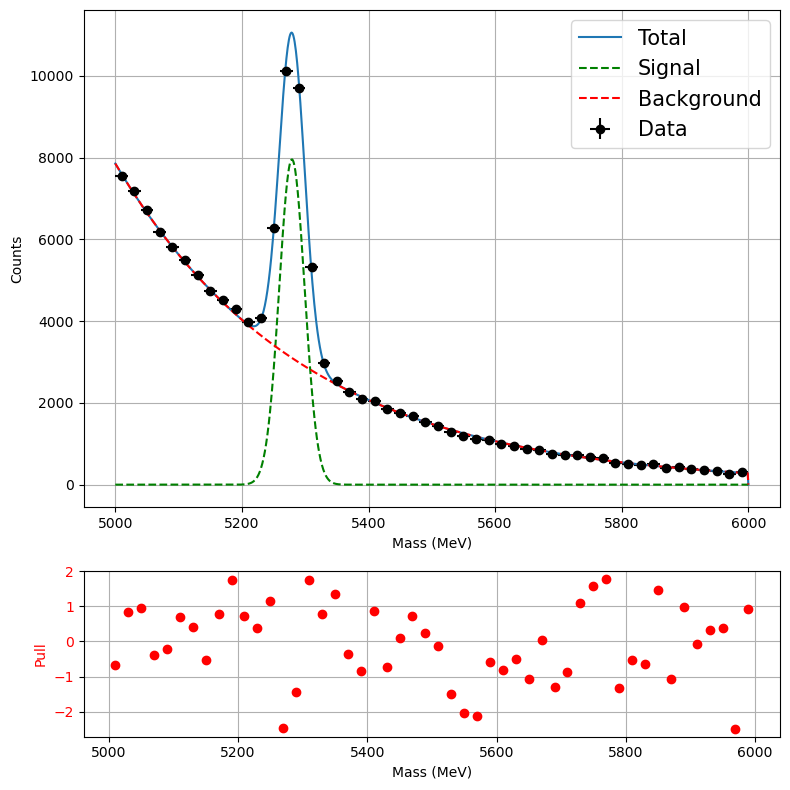

In [14]:
plot_mass(np_m_sw, xr, m)

In [15]:
C = np.array(m.covariance)[0:2, 0:2]

In [16]:
values = [truncnorm.pdf(np_m_sw, *xr, 5279, 20), truncexpon.pdf(np_m_sw, *xr, 0.0, 300)]
yields = [m.values['s'], m.values['b']]

sWeights = compute_sweights(values, yields, C)[0]

data_df['sWeights'] = sWeights

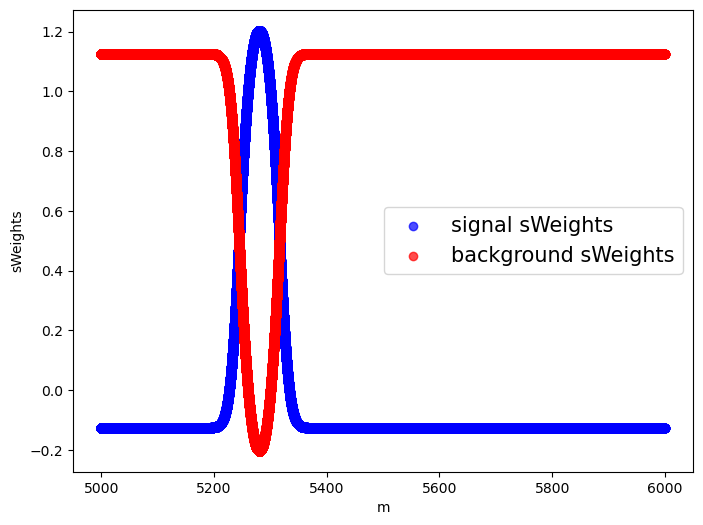

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the full lifetime distribution
ax.scatter(data_df['mass'], data_df['sWeights'], alpha=0.7, color='blue', label = 'signal sWeights')
ax.scatter(data_df['mass'], 1 - data_df['sWeights'], alpha=0.7, color='red', label = 'background sWeights')
ax.legend(fontsize=15)

# Labels and title
ax.set_xlabel("m")
ax.set_ylabel("sWeights")

plt.show()

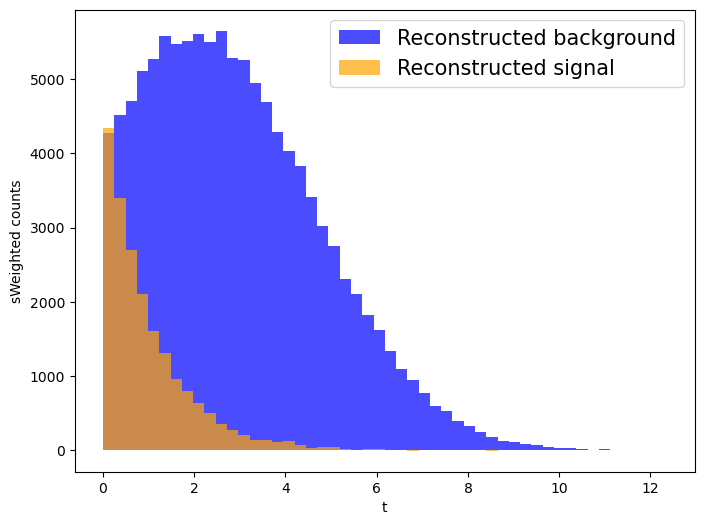

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the full lifetime distribution
ax.hist(data_df['lifetime'], alpha=0.7, color='blue',bins = 50, weights = 1 - data_df['sWeights'], label = 'Reconstructed background')
ax.hist(data_df['lifetime'], alpha=0.7, color='orange',bins = 50, weights = data_df['sWeights'], label = 'Reconstructed signal')
# Labels and title
ax.set_xlabel("t")
ax.set_ylabel("sWeighted counts")
ax.legend(fontsize=15)

plt.show()

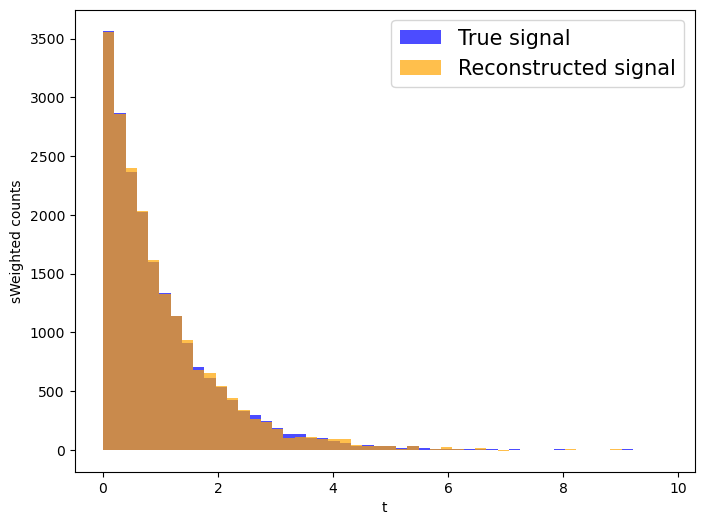

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the full lifetime distribution
_, bins, _ = ax.hist(np_sig_t_sw, alpha=0.7, color='blue',bins = 50, label = 'True signal')
ax.hist(data_df['lifetime'], alpha=0.7, color='orange',bins = bins, weights = data_df['sWeights'], label = 'Reconstructed signal')
# Labels and title
ax.set_xlabel("t")
ax.set_ylabel("sWeighted counts")
ax.legend(fontsize=15)

plt.show()

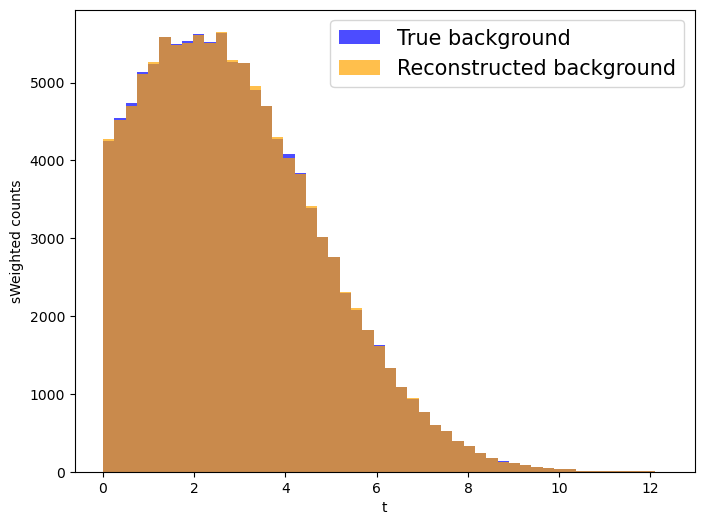

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the full lifetime distribution
_, bins, _ = ax.hist(np_bkg_t_sw, alpha=0.7, color='blue',bins = 50, label = 'True background')
ax.hist(data_df['lifetime'], alpha=0.7, color='orange',bins = bins, weights = 1 - data_df['sWeights'], label = 'Reconstructed background')
# Labels and title
ax.set_xlabel("t")
ax.set_ylabel("sWeighted counts")
ax.legend(fontsize=15)

plt.show()

- Signal and background lifetime distributions (t) are correctly disentangled.
- Requires only a single normalisation fit with two free parameters.

## Impact of uncertainties in sWeights extracted from the data

$$
\sigma^2(s)=\sum_{\text {bins } k}\left[w_k^2+\sigma^2\left(w_k\right)\right] a_k=\sum_{\text {events } k}\left[w_k^2+O\left(\frac{1}{N}\right)\right]
$$

- asymptotically the variance in a $\Delta t$-bin is $\sum w^2$
- for finite statistics there are corrections of $O(1 / N)$
- $O(1 / N)$ terms occur also as covariances between bins

## Fitting shape parameters in addition to the yield parameters

- With the shape parameters in the covariance matrix, the modified covariance matrix will then produce the wrong sWeights and biased results.

- Need to adapt the procedure slightly:

1. First fit with all the parameters floating,

2. Then fix the shape parameters, and get the covariance matrix from the pure normalisation fit.

## sWeights as orthogonal functions

### Properties of the sWeights classic

- Can disentagle signal and background

- Though, can not deal with constraints on yield ratios: would change the underlying covariance matrix

- Also, can not change mass ranges.

## Reformulation of sWeight method

Starting from the data model ...

$$
f(m, t)=N_0 d_0(m) s(t)+N_1 d_1(m) b(t)
$$


approximation by the sum over sWeights

$$
s(\Delta t)=\int_{\Delta t} d t N_0 s(t)=\sum_{\text {entries in } \Delta t} w_s(m)
$$


replace the sum by the integral over the density

$$
s(\Delta t)=\int_{\Delta t} d t N_0 s(t)=\sum_{\text {entries in } \Delta t} w_s(m)=\int_{\Delta t} d t \int d m f(m, t) w_s(m)
$$


relation between signal density, data model and sWeights

$$
N_0 s(t)=\int d m f(m, t) w_s(m)
$$


substitute the explicit form for $f(m, t)$

$$
N_0 s(t)=\int d m f(m, t) w_s(m)=\int d m\left[N_0 d_0(m) s(t)+N_1 d_1(m) b(t)\right] w_s(m)
$$


separate into a sum of two integrals

$$
\begin{aligned}
N_0 s(t) = N_0 s(t) \int d m d_0(m) w_s(m)+N_1 b(t) \int d m d_1(m) w_s(m)
\end{aligned}
$$


### Key observation

$$
\int d m d_0(m) w_s(m)=1 \quad \text { and } \quad \int d m d_1(m) w_s(m)=0
$$

- $w_s(m)$ is orthogonal to the background PDF $d_1(m)$
- $w_s(m)$ is normalised with respect to the signal PDF $d_0(m)$
- infinitely many functions satisfy these constraints
- select the one that minimises the variance of the total signal yield

$$
\begin{aligned}
N_0 & =\sum_{\text {events }} w_s(m) \\
\sigma^2\left(N_0\right)=\sum_{\text {events }} w_s^2(m) & =\int d t d m f(m, t) w_s^2(m)=\min
\end{aligned}
$$


### Result

$$
w_s(m)=\frac{\alpha_0 d_0(m)+\alpha_1 d_1(m)}{N_0 d_0(m)+N_1 d_1(m)}
$$

with $\alpha_0$ and $\alpha_1$ given by the solution of a matrix equation

$$
\left(\begin{array}{ll}
W_{00} & W_{01} \\
W_{01} & W_{11}
\end{array}\right) \cdot\binom{\alpha_0}{\alpha_1}=\binom{1}{0} \quad \text { and } \quad W_{k l}=\int d m \frac{d_k(m) d_l(m)}{N_0 d_0(m)+N_1 d_1(m)}
$$


- the result is equivalent to the normalisation-fit recipe
- the optimal weights can be calculated directly from the measurement model
- no-refit needed after fitting shape parameters or when changing $m$-ranges
- any uncertainties on $N_0, N_1$ or shapes can be propagated into $w_s(m)$

## sWeight implementations

1. via Extended Maximum Likelihood fit of signal and background yields,
2. numerical/analytical calculation of $W_{k l}$,
3. plug-in estimate for $W_{k l}$ based on data:
- express the $W_{k l}$ integral as an expectation value over the $m$-density
- estimate this expectation value from the data

$$
\begin{aligned}
W_{k l}  =\int d m \frac{d_k(m) d_l(m)}{N_0 d_0(m)+N_1 d_1(m)} \\
 =N \int d m \frac{d_k(m) d_l(m)}{\left(N_0 d_0(m)+N_1 d_1(m)\right)^2}\left(\frac{N_0}{N} d_0(m)+\frac{N_1}{N} d_1(m)\right) \\
 =N\left\langle\frac{d_k(m) d_l(m)}{\left(N_0 d_0(m)+N_1 d_1(m)\right)^2}\right\rangle \rightarrow \sum_i \frac{d_k\left(m_i\right) d_l\left(m_i\right)}{\left(\hat{N}_0 d_0\left(m_i\right)+\hat{N}_1 d_1\left(m_i\right)\right)^2}
\end{aligned}
$$

for finite $N$ this scheme satisfies $\sum w_s=\hat{N}_0$

In [21]:
# Define sweights functions (for iMinuit usage) for each bin:

def compute_sweight_matrix(values, yields):
		"""
		Compute the sWeight covariance matrix (V) for a set of sources.

		This function calculates the sWeight covariance matrix (V) for a set of sources,
		given the PDF values and yields for each source.

		Parameters:
		- values: 2D array-like (n_samples x n_sources)
			A matrix where each row corresponds to a sample, and each column corresponds 
			to the PDF values for a particular source (e.g., signal, background, etc.).
		- yields: 1D array-like (n_sources)
			An array containing the yields for each source.

		Returns:
		- V: 2D numpy array (n_sources x n_sources)
			The sWeight covariance matrix (V), which can be used to calculate sWeights 
			for each source.
		"""
			
		# Convert inputs to numpy arrays
		pdf_val = np.array(values)
		yields_arr = np.array(yields)
		# Compute the total squared normalization term
		total_squared = np.dot(yields_arr, pdf_val)**2

		# Initialize the inverse covariance matrix (V_inv)
		V_inv = np.zeros((len(yields), len(yields)))

		# Compute the elements of V_inv
		for i in range(len(yields)):
			for j in range(len(yields)):
				V_inv[i, j] = np.dot(pdf_val[i] / total_squared, pdf_val[j])

		# Compute the covariance matrix V by inverting V_inv
		V = np.linalg.inv(V_inv)

		return V


In [22]:
# Now floating shape parameters:
def density(x, s, b, mu, sigma, tau):
    return s + b, (s * truncnorm.pdf(x, *xr, mu, sigma) + b * truncexpon.pdf(x, *xr, 0.0, tau))
c = cost.ExtendedUnbinnedNLL(np_m_sw, density)
m = Minuit(c, s=20000, b=150000, mu=5279, sigma=20, tau=300)
m.limits["s", "b"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.156e+06                 │              Nfcn = 76               │
│ EDM = 5.19e-06 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  19.91e3  │  0.20e3   │            │            │    0    │         │       │
│ 1 │ b     │  113.6e3  │   0.4e3   │            │            │    0    │         │       │
│ 2 │ mu    │ 5.27910e3 │ 0.00022e3 │            │            │         │         │       │
│ 3 │ sigma │   19.91   │   0.20    │            │            │         │         │       │
│ 4 │ tau   │   298.4   │    1.2    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │         s         b        mu     sigma       tau │
├───────┼───────────────────────────────────────────────────┤
│     s │   3.8e+04 -1.84e+04     -2.23      17.2     -4.91 │
│     b │ -1.84e+04  1.69e+05     0.356     -17.9      2.97 │
│    mu │     -2.23     0.356    0.0488  -0.00192  -0.00839 │
│ sigma │      17.2     -17.9  -0.00192    0.0416  -0.00358 │
│   tau │     -4.91      2.97  -0.00839  -0.00358      1.36 │
└───────┴───────────────────────────────────────────────────┘

In [23]:
values = [truncnorm.pdf(np_m_sw, *xr, m.values['mu'], m.values['sigma']), truncexpon.pdf(np_m_sw, *xr, 0.0, m.values['tau'])]
yields = [m.values['s'], m.values['b']]

V = compute_sweight_matrix(values, yields)
sWeights = compute_sweights(values, yields, V)[0]

data_df['sWeights'] = sWeights

In [24]:
print('Sum of the sWeights: ', sWeights.sum(), 'match with the fit signal amount: ', m.values['s'])

Sum of the sWeights:  19909.62024027068 match with the fit signal amount:  19909.620240270702


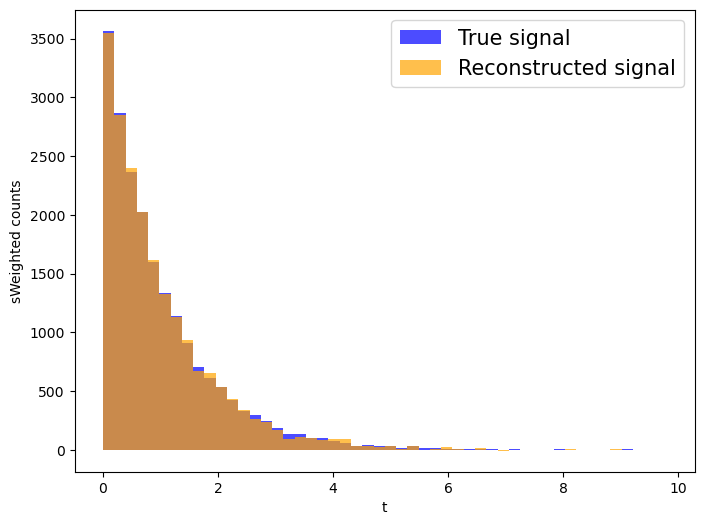

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the full lifetime distribution
_, bins, _ = ax.hist(np_sig_t_sw, alpha=0.7, color='blue',bins = 50, label = 'True signal')
ax.hist(data_df['lifetime'], alpha=0.7, color='orange',bins = bins, weights = data_df['sWeights'], label = 'Reconstructed signal')
# Labels and title
ax.set_xlabel("t")
ax.set_ylabel("sWeighted counts")
ax.legend(fontsize=15)

plt.show()

## Important requirement of sPlot

Reconstructed control variables (i.e. lifetime, $p$) and discriminant variables (i.e. mass) should be statistically independent within each class. So you can not reconstruct variables that are correlated to the discriminant variable.

As an example you can try to reconstruct the mass variable with sWeights (mass is correlated with mass):

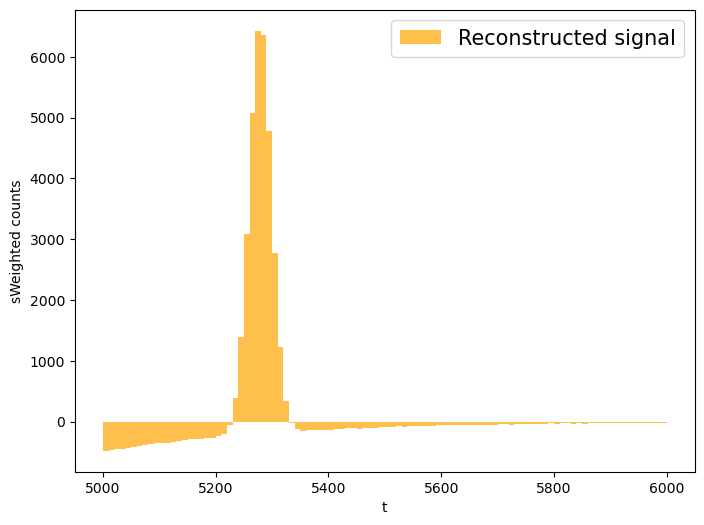

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the full lifetime distribution
ax.hist(data_df['mass'], alpha=0.7, color='orange',bins = 100, weights = data_df['sWeights'], label = 'Reconstructed signal')
# Labels and title
ax.set_xlabel("t")
ax.set_ylabel("sWeighted counts")
ax.legend(fontsize=15)

plt.show()

## Efficiency corrected yields

The sPlot formalism can be applied also to extract physics results. One may be interested in a particular signal yield provided by the likelihood fit from a selection efficiency ($\epsilon(x)$). 


You can use the sum:
$$
\begin{aligned}
\sum_{\text {events }} \frac{w_s^2(m)}{\epsilon(x)} 
\end{aligned}
$$

to compute the efficiency corrected yields.

Useful links/papers:
https://indico.cern.ch/event/940874/timetable/
https://indico.cern.ch/event/940874/contributions/3953536/attachments/2127102/3581512/langenbruch.pdf
https://arxiv.org/pdf/1911.01303
https://indico.cern.ch/event/940874/contributions/3953530/attachments/2127199/3581560/sweights_ms.pdf
http://arogozhnikov.github.io/2015/10/07/splot.html
https://arxiv.org/pdf/physics/0402083
https://hsf-training.github.io/analysis-essentials/advanced-python/60sPlot.html